In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
sessions = pd.read_csv('data/sessions.csv', index_col=0)
pilots = pd.read_csv('data/pilots.csv', index_col=0)
units = pd.read_csv('data/units.csv', index_col=0)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sessions.loc[(sessions['nunit'] >= 4   ) & (sessions['nunit'] < 8   ), 'nunit_requested'] = 4
sessions.loc[(sessions['nunit'] >= 8   ) & (sessions['nunit'] < 16  ), 'nunit_requested'] = 8
sessions.loc[(sessions['nunit'] >= 16  ) & (sessions['nunit'] < 32  ), 'nunit_requested'] = 16
sessions.loc[(sessions['nunit'] >= 32  ) & (sessions['nunit'] < 64  ), 'nunit_requested'] = 32
sessions.loc[(sessions['nunit'] >= 64  ) & (sessions['nunit'] < 128 ), 'nunit_requested'] = 64
sessions.loc[(sessions['nunit'] >= 128 ) & (sessions['nunit'] < 256 ), 'nunit_requested'] = 128
sessions.loc[(sessions['nunit'] >= 256 ) & (sessions['nunit'] < 512 ), 'nunit_requested'] = 256
sessions.loc[(sessions['nunit'] >= 512 ) & (sessions['nunit'] < 1024), 'nunit_requested'] = 512
sessions.loc[(sessions['nunit'] >= 1024) & (sessions['nunit'] < 2048), 'nunit_requested'] = 1024
sessions.loc[(sessions['nunit'] >= 2048) & (sessions['nunit'] < 4096), 'nunit_requested'] = 2048
sessions.loc[(sessions['nunit'] >= 4096) & (sessions['nunit'] < 8192), 'nunit_requested'] = 4096

sessions['nunit_rescheduled'] = sessions['nunit'] - sessions['nunit_requested']

In [5]:
stampede = ['rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017261.0002', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017261.0003', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0001', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0007']
comet = ['rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017261.0000', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0004', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017267.0013', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017269.0001']
supermic_matteo = ['rp.session.one.mturilli.017239.0009', 'rp.session.one.mturilli.017238.0011', 'rp.session.one.mturilli.017239.0010', 'rp.session.one.mturilli.017238.0012', 'rp.session.one.mturilli.017239.0011', 'rp.session.one.mturilli.017238.0013', 'rp.session.one.mturilli.017239.0014', 'rp.session.one.mturilli.017238.0014', 'rp.session.one.mturilli.017239.0017', 'rp.session.one.mturilli.017238.0017', 'rp.session.one.mturilli.017239.0018', 'rp.session.one.mturilli.017238.0018', 'rp.session.one.mturilli.017239.0019', 'rp.session.one.mturilli.017239.0003', 'rp.session.one.mturilli.017239.0020', 'rp.session.one.mturilli.017239.0005', 'rp.session.one.mturilli.017239.0021', 'rp.session.one.mturilli.017239.0006', 'rp.session.one.mturilli.017239.0022', 'rp.session.one.mturilli.017239.0007']
supermic_ming = ['rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017261.0004', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0000', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0002', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0003', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0004', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0005', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0006', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0007', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0008', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0009', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017262.0010', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017263.0001', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0001', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0002', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0003', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0004', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0005', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0006', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0007', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0008', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0009', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0010', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0011', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0012', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0013', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0014', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0015', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0016', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0017', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0018', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0019', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0020', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0022', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0023', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0024', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0025', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0026', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0027', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0028', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0029', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0030', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0031', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0032', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0033', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0034', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0035', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0036', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0037', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0038', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0039', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0040', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0041', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0042', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0043', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0044', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017265.0045', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0005', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0008', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0009', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0010', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0011', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0012', 'rp.session.Ubuntu-1604-xenial-64-minimal.mingtha.017266.0013']
supermic = supermic_matteo+supermic_ming

ustampede = units.loc[units.sid.isin(stampede)]
ucomet = units.loc[units.sid.isin(comet)]
usupermic_matteo = units.loc[units.sid.isin(supermic_matteo)]
usupermic_ming = units.loc[units.sid.isin(supermic_ming)]
usupermic = units.loc[units.sid.isin(supermic)]

In [6]:
print 'Number of units run on Stampede: %s' % ustampede.shape[0]
print 'Number of units run on Comet: %s' % ucomet.shape[0]
print 'Number of units run on SuperMIC (Matteo\'s experiments): %s' % usupermic_matteo.shape[0]
print 'Number of units run on SuperMIC (Ming\'s experiments): %s' % usupermic_ming.shape[0]
print 'Number of units run on SuperMIC: %s' % usupermic.shape[0]

Number of units run on Stampede: 3088
Number of units run on Comet: 3088
Number of units run on SuperMIC (Matteo's experiments): 20480
Number of units run on SuperMIC (Ming's experiments): 63504
Number of units run on SuperMIC: 83984


## Experiment 1

NormaltestResult(statistic=2998.6126375184936, pvalue=0.0)

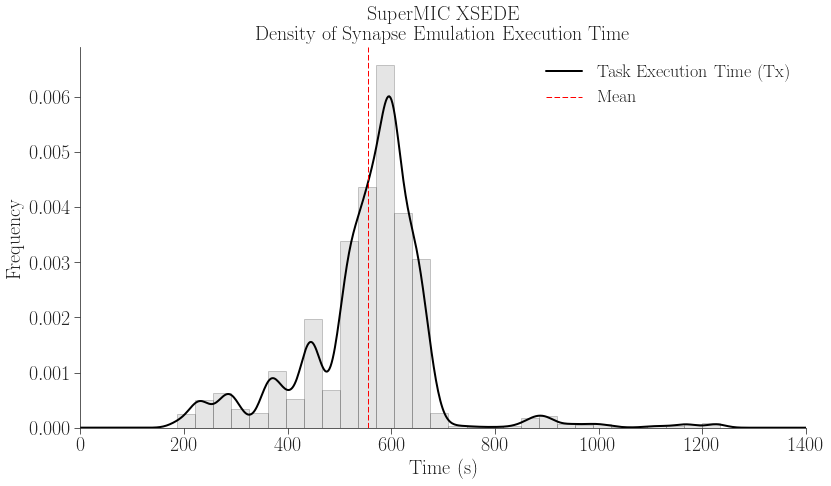

In [7]:
fig, ax = fig_setup()
title='SuperMIC XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
display(sps.normaltest(usupermic_matteo['U_AGENT_EXECUTING'].dropna().tolist()))
usupermic_matteo[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
usupermic_matteo[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=30, 
                alpha = 0.20,
                normed=True)

plt.axvline(usupermic_matteo['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlim(0,1400)
plt.xlabel('Time (s)')

ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

plt.savefig('figures/supermic_matteo_tx_frequency.pdf', dpi=600, bbox_inches='tight')

NormaltestResult(statistic=7452.0934456272289, pvalue=0.0)

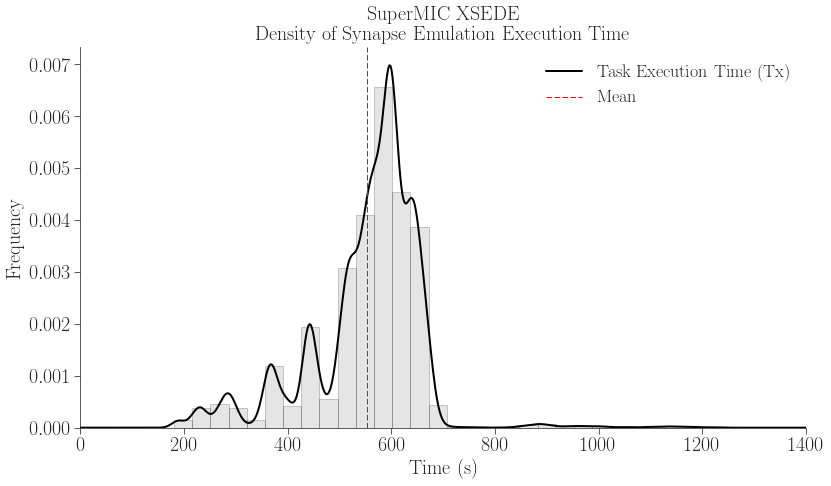

In [8]:
fig, ax = fig_setup()
title='SuperMIC XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
display(sps.normaltest(usupermic_ming['U_AGENT_EXECUTING'].dropna().tolist()))
usupermic_ming[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
usupermic_ming[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=30, 
                alpha = 0.20,
                normed=True)

plt.axvline(usupermic_ming['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlim(0,1400)
plt.xlabel('Time (s)')

ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

plt.savefig('figures/supermic_ming_tx_frequency.pdf', dpi=600, bbox_inches='tight')

NormaltestResult(statistic=8736.0165585265077, pvalue=0.0)

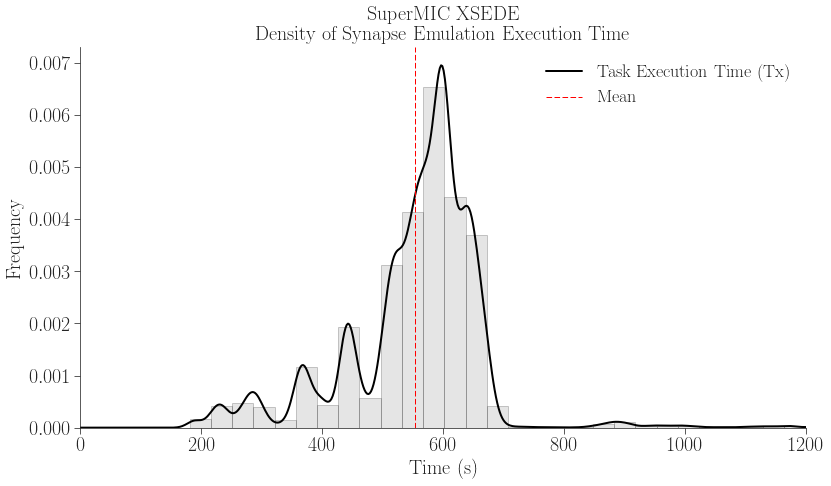

In [23]:
fig, ax = fig_setup()
title='SuperMIC XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
display(sps.normaltest(usupermic['U_AGENT_EXECUTING'].dropna().tolist()))
usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=30, 
                alpha = 0.20,
                normed=True)

plt.axvline(usupermic['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlim(0,1200)
plt.xlabel('Time (s)')

ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

plt.savefig('figures/supermic_tx_frequency.pdf', dpi=600, bbox_inches='tight')

83984


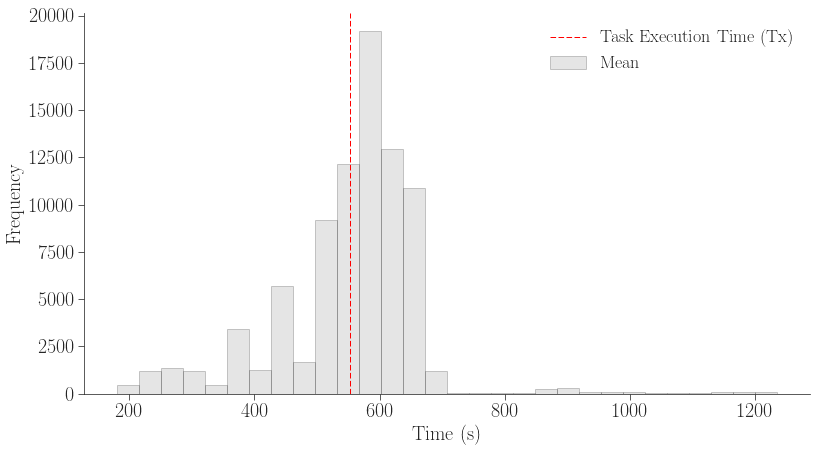

In [25]:
fig, ax = fig_setup()
title='SuperMIC XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
#display(sps.normaltest(usupermic['U_AGENT_EXECUTING'].dropna().tolist()))
#usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram
print usupermic.shape[0]
usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=30, 
                alpha = 0.20) #,
                # normed=True)

plt.axvline(usupermic['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim(0,1400)
plt.xlabel('Time (s)')

ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

# plt.savefig('figures/supermic_tx_frequency.pdf', dpi=600, bbox_inches='tight')

NormaltestResult(statistic=174.83328147962214, pvalue=1.0850138956516921e-38)

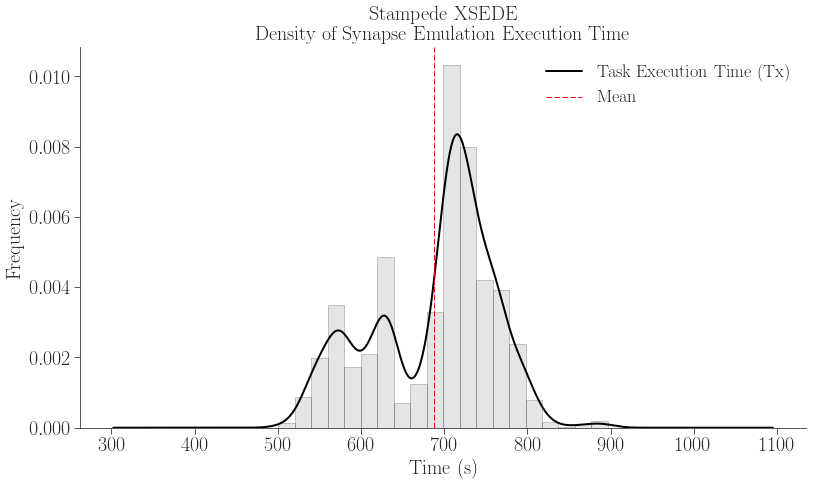

In [10]:
fig, ax = fig_setup()
title='Stampede XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
display(sps.normaltest(ustampede['U_AGENT_EXECUTING'].dropna().tolist()))
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=20, 
                alpha = 0.20,
                normed=True)

plt.axvline(ustampede['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

#ax.set_xlim(0,1400)
plt.xlabel('Time (s)')

ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

plt.savefig('figures/stampede_tx_frequency.pdf', dpi=600, bbox_inches='tight')

NormaltestResult(statistic=3943.4043745072331, pvalue=0.0)

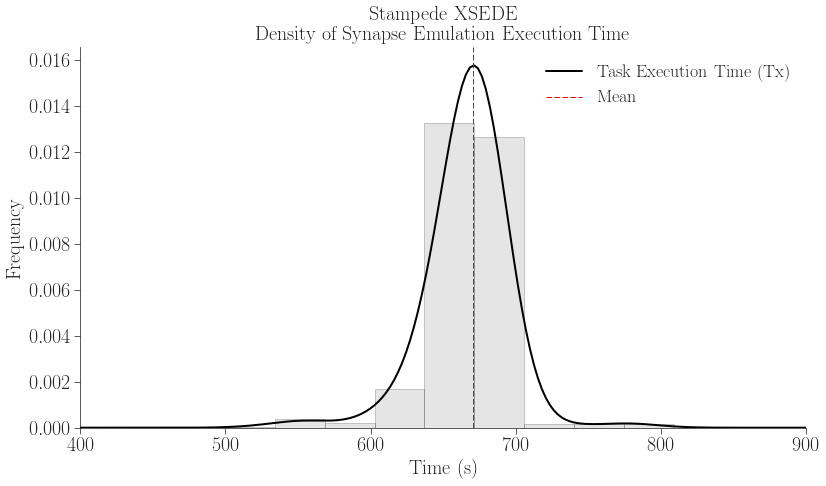

In [11]:
fig, ax = fig_setup()
title='Stampede XSEDE\nDensity of Synapse Emulation Execution Time'

# KDE execution time
display(sps.normaltest(ucomet['U_AGENT_EXECUTING'].dropna().tolist()))
ucomet[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
ucomet[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray',
                edgecolor="k",
                bins=40, 
                alpha = 0.20,
                normed=True)

plt.axvline(ucomet['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlim(400,900)
plt.xlabel('Time (s)')

ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

plt.savefig('figures/stampede_tx_frequency.pdf', dpi=600, bbox_inches='tight')

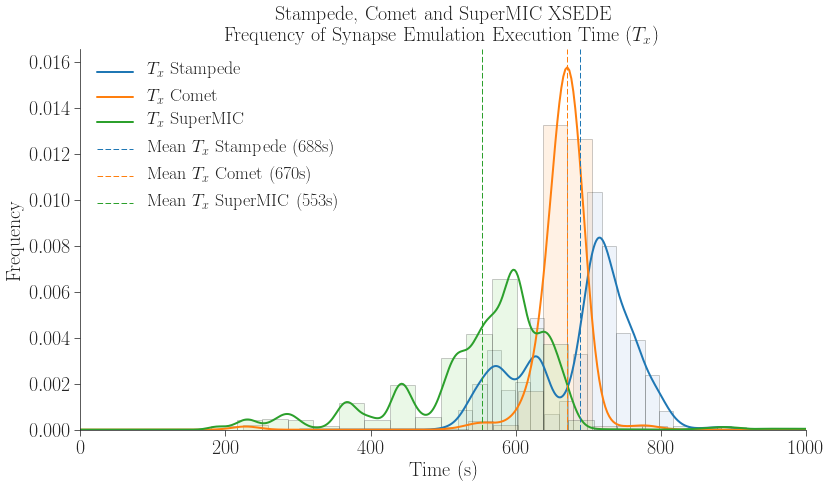

In [21]:
fig, ax = fig_setup()
title='Stampede, Comet and SuperMIC XSEDE\nFrequency of Synapse Emulation Execution Time ($T_x$)'

# KDE execution time
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color=tableau20[0], title=title)
ucomet[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color=tableau20[2], title=title)
usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color=tableau20[4], title=title)

# Normed Histogram
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color=tableau20[1],
                edgecolor="k",
                bins=20, 
                alpha = 0.20,
                normed=True)

ucomet[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color=tableau20[3],
                edgecolor="k",
                bins=40, 
                alpha = 0.20,
                normed=True)

usupermic[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color=tableau20[5],
                edgecolor="k",
                bins=30, 
                alpha = 0.20,
                normed=True)

plt.axvline(ustampede['U_AGENT_EXECUTING'].dropna().mean(), color=tableau20[0], linestyle='dashed', linewidth=1)
plt.axvline(ucomet['U_AGENT_EXECUTING'].dropna().mean(), color=tableau20[2], linestyle='dashed', linewidth=1)
plt.axvline(usupermic['U_AGENT_EXECUTING'].dropna().mean(), color=tableau20[4], linestyle='dashed', linewidth=1)

ax.set_xlim(0, 1000)
plt.xlabel('Time (s)')

ax.legend(labels=['$T_x$ Stampede', '$T_x$ Comet', '$T_x$ SuperMIC', 
                  'Mean $T_x$ Stampede (%is)' % ustampede['U_AGENT_EXECUTING'].dropna().mean(), 
                  'Mean $T_x$ Comet (%is)' % ucomet['U_AGENT_EXECUTING'].dropna().mean(), 
                  'Mean $T_x$ SuperMIC (%is)' % usupermic['U_AGENT_EXECUTING'].dropna().mean()])

plt.savefig('figures/xsede_tx_frequency.pdf', dpi=600, bbox_inches='tight')